# Dolar Mep Data Analysis

La idea de este notebook es analizar posibles algoritmos para hacer predicciones con TimeSeries del valor del dolar MEP.

Buscamos: 
- Predecir el dolar MEP de cierre dado un dia y un valor de apertura

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datetime as dt
from sklearn.metrics import mean_squared_error

# graphing settings
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

# Analisis de datos

In [5]:
df = pd.read_csv('../datasets/rava-dolar-mep-historico.csv')
df = df.set_index('fecha')
df.index = pd.to_datetime(df.index)

In [6]:
df.head(2)

,especie,ultimo,variacion,anterior,apertura,minimo,maximo,varMTD,varYTD,var6M,var12M,hora,cierre,timestamp,volumen
fecha,,,,,,,,,,,,,,,
2018-10-29,DOLAR MEP,36.97,NaN,NaN,36.97,36.97,36.97,NaN,NaN,NaN,NaN,NaN,36.97,1540782000,0
2018-10-30,DOLAR MEP,36.63,0.0,0.0,36.63,36.63,36.63,NaN,NaN,NaN,NaN,19:59,36.63,1540868400,0


In [7]:
def setTimeFeatures(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter # quarter of year
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = setTimeFeatures(df)

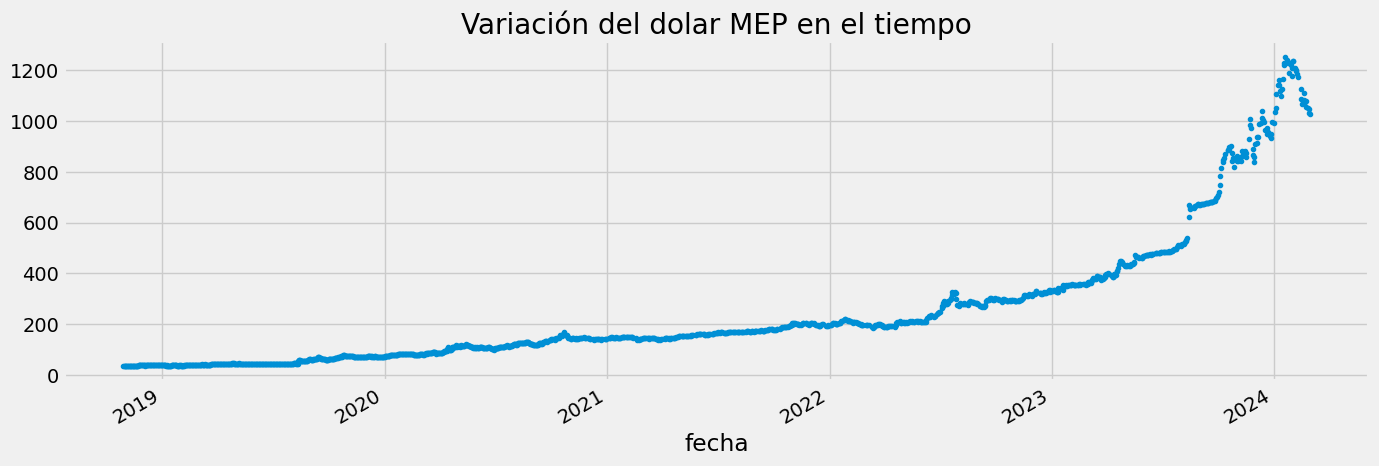

In [8]:
df['cierre'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Variación del dolar MEP en el tiempo')
plt.show()

### Acortamos el periodo

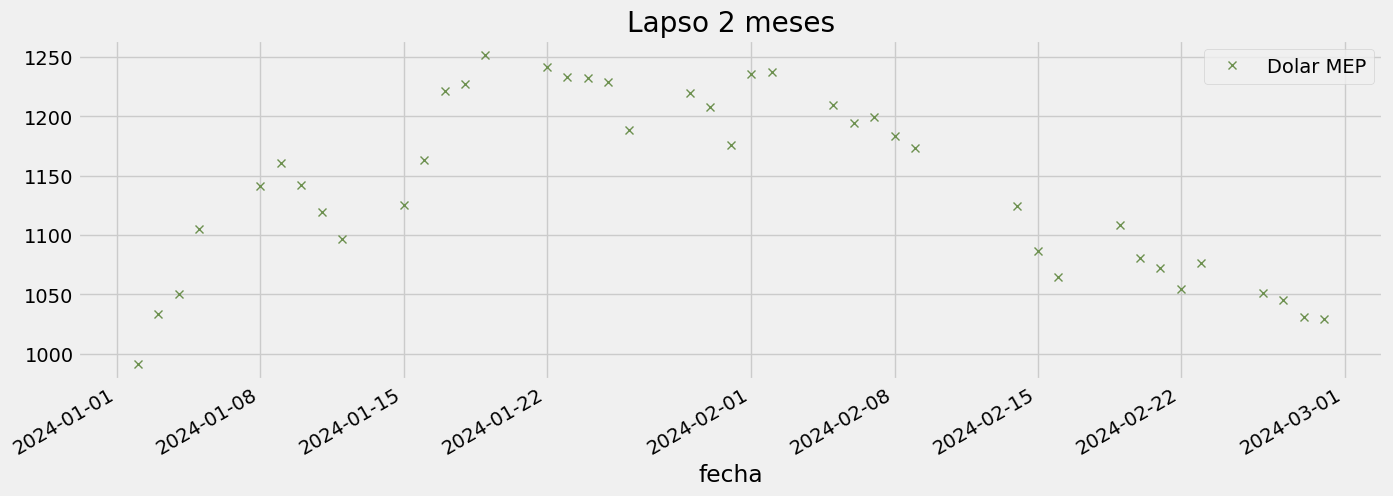

In [9]:
df['cierre'].loc[(df.index > '01-01-2024') & (df.index < '04-01-2024')] \
    .plot(figsize=(15, 5), title='Lapso 2 meses', style='x', color=color_pal[3])
plt.legend(['Dolar MEP'])
plt.show()

In [10]:
avgMedicionesMensuales = df['cierre'].resample('M').size().mean()
print('Cantidad de mediciones mensuales promedio: ', avgMedicionesMensuales)

Cantidad de mediciones mensuales promedio:  23.50769230769231


C:\Users\sebas\AppData\Local\Temp\ipykernel_14228\2087232887.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avgMedicionesMensuales = df['cierre'].resample('M').size().mean()


### Vemos la variacion semanal

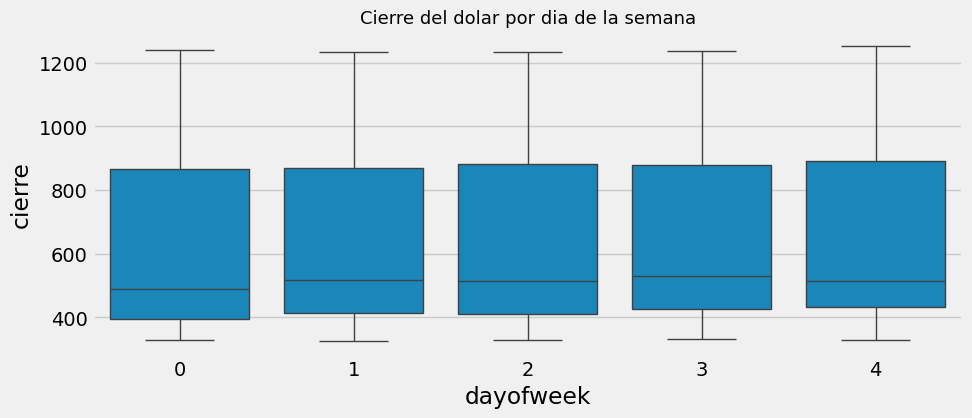

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df[df.index>'01-01-2023'], x='dayofweek', y='cierre')
ax.set_title('Cierre del dolar por dia de la semana', fontsize=13)
plt.show()

In [12]:
df[df.index>'01-01-2023'].tail(2)

,especie,ultimo,variacion,anterior,apertura,minimo,maximo,varMTD,varYTD,var6M,...,cierre,timestamp,volumen,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
fecha,,,,,,,,,,,,,,,,,,,,,
2024-02-28,DOLAR MEP,1031.25,-1.3,1044.95,1044.95,1020.20,1067.49,NaN,NaN,NaN,...,1031.25,1709089200,0,2,1,2,2024,59,28,9
2024-02-29,DOLAR MEP,1028.94,-0.2,1031.25,1031.25,1026.16,1046.08,NaN,NaN,NaN,...,1028.94,1709175600,0,3,1,2,2024,60,29,9


## Limpieza de datos

In [13]:
df.columns

Index(['especie', 'ultimo', 'variacion', 'anterior', 'apertura', 'minimo',
       'maximo', 'varMTD', 'varYTD', 'var6M', 'var12M', 'hora', 'cierre',
       'timestamp', 'volumen', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

Especie: hay una sola (dolar mep)

In [14]:
df = df.drop('especie', axis=1)

Ultimo: Es igual al cierre

In [15]:
df = df.drop('ultimo', axis=1)

Hora: son mediciones diarias

In [16]:
df['hora'].groupby(df.hora).count()

hora
16:19       1
17:00       1
19:00       1
19:51       1
19:58       2
19:59    1248
Name: hora, dtype: int64

In [17]:
df = df.drop('hora', axis=1)

Variacion: Es la diferencia entre el cierre y la apertura diaria.

In [18]:
df[['cierre', 'apertura', 'variacion']].tail(3)

,cierre,apertura,variacion
fecha,,,
2024-02-27,1044.95,1051.04,-0.6
2024-02-28,1031.25,1044.95,-1.3
2024-02-29,1028.94,1031.25,-0.2


In [19]:
df = df.drop('apertura', axis=1)

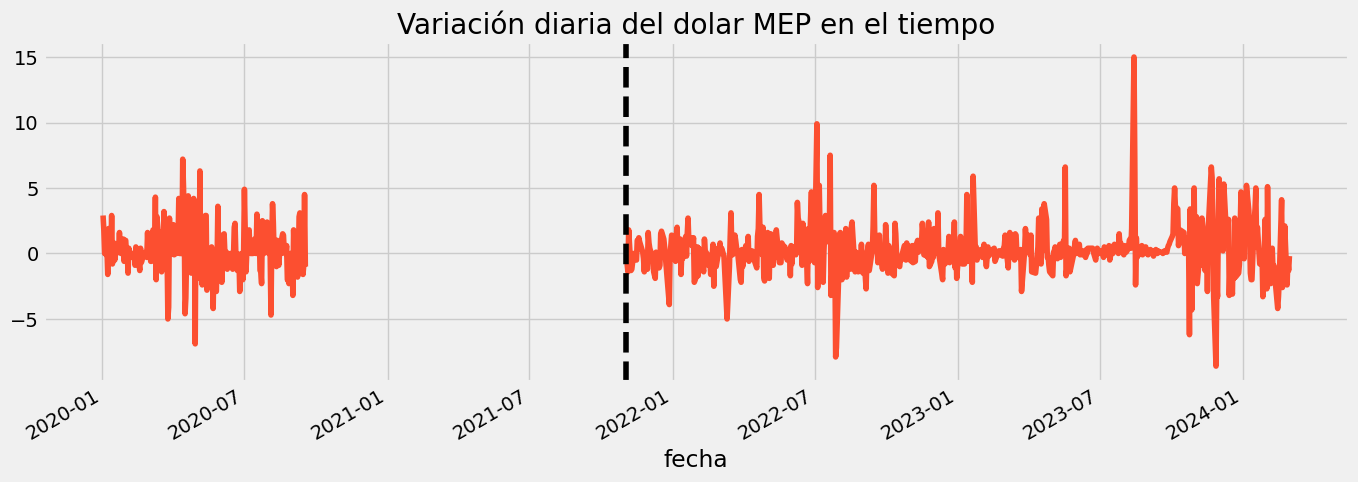

In [20]:
# creamos un unico gráfico para visualizar la separación
fig, ax = plt.subplots(figsize=(15, 5))

df['variacion'].loc[df.index > "01-01-2020"].plot(ax=ax, title='Variación diaria del dolar MEP en el tiempo', color=color_pal[1])

# agregamos una línea vertical para separar los conjuntos
ax.axvline('11-01-2021', color='black', ls='--')

plt.show()

In [21]:
# sacamos esta columna, no es un input valido para las predicciones que buscamos
df = df.drop('variacion', axis=1)
df.head(2)

,anterior,minimo,maximo,varMTD,varYTD,var6M,var12M,cierre,timestamp,volumen,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
fecha,,,,,,,,,,,,,,,,,
2018-10-29,NaN,36.97,36.97,NaN,NaN,NaN,NaN,36.97,1540782000,0,0,4,10,2018,302,29,44
2018-10-30,0.0,36.63,36.63,NaN,NaN,NaN,NaN,36.63,1540868400,0,1,4,10,2018,303,30,44


Maximo y minimo: (Estimo) son los picos max/min del dia
- Ninguna fila es NaN

In [22]:
df[['cierre', 'maximo', 'minimo']].tail(5)

,cierre,maximo,minimo
fecha,,,
2024-02-23,1076.60,1077.98,1040.00
2024-02-26,1051.04,1093.80,1040.33
2024-02-27,1044.95,1060.28,1043.47
2024-02-28,1031.25,1067.49,1020.20
2024-02-29,1028.94,1046.08,1026.16


In [23]:
df['maximo'].isna().sum() == df['minimo'].isna().sum() == 0

True

Las variaciones 'varMTD', 'varYTD', 'var6M', 'var12M' no tienen datos

In [24]:
for col in ['varMTD', 'varYTD', 'var6M', 'var12M']:
    count = df[col].count()
    print(f"nonNan values '{col}': ", count)
    if count == 0:
       df = df.drop(col, axis=1)

nonNan values 'varMTD':  0
nonNan values 'varYTD':  0
nonNan values 'var6M':  0
nonNan values 'var12M':  0


Volumen: valen todos 0, no sirve

In [25]:
df['volumen'].nunique()
df = df.drop('volumen', axis=1)

## Armado de features

In [26]:
df.columns

Index(['anterior', 'minimo', 'maximo', 'cierre', 'timestamp', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [82]:
from sklearn.model_selection import train_test_split

features = [
    'anterior',
    'timestamp', 'dayofweek', 'quarter', 'month', 'year',
    'dayofyear', 'dayofmonth', 'weekofyear']
target = 'cierre'


df = df[df.index > '11-15-2021']
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Armamos modelos XGBoost

#### [1] Modelo Booster Lineal

In [99]:
reg1 = xgb.XGBRegressor(
        three_method='hist', # metodo           
        booster='gblinear', # metodo
        n_estimators=6000, # numero de arboles
        early_stopping_rounds=100, # detiene el entrenamiento si no mejora
        max_depth=4, # maxima profundidad de los arboles --> overfitting
        learning_rate=0.008)

reg1.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], # cross-validation metrics
        verbose=1000)

[0]	validation_0-rmse:285.76492	validation_1-rmse:291.76438


c:\Users\sebas\Proyectos\BotFinanciero\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [20:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_depth", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:55.25541	validation_1-rmse:57.04236
[2000]	validation_0-rmse:19.46837	validation_1-rmse:19.17139
[3000]	validation_0-rmse:14.02720	validation_1-rmse:13.14092
[4000]	validation_0-rmse:13.43832	validation_1-rmse:12.42211
[5000]	validation_0-rmse:13.36544	validation_1-rmse:12.31529
[5999]	validation_0-rmse:13.34219	validation_1-rmse:12.28313


XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Model Boost Tree

In [100]:
reg2 = xgb.XGBRegressor(
        three_method='hist', # metodo           
        booster='gbtree', # metodo
        n_estimators=5000, # numero de arboles
        early_stopping_rounds=50, # detiene el entrenamiento si no mejora
        max_depth=3, # maxima profundidad de los arboles --> overfitting
        learning_rate=0.005)

reg2.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], # cross-validation metrics
    verbose=500)

[0]	validation_0-rmse:285.02254	validation_1-rmse:290.86329


c:\Users\sebas\Proyectos\BotFinanciero\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [20:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:27.60048	validation_1-rmse:28.59202
[1000]	validation_0-rmse:7.42379	validation_1-rmse:12.19366
[1500]	validation_0-rmse:5.84336	validation_1-rmse:11.51623
[1520]	validation_0-rmse:5.81468	validation_1-rmse:11.52029


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Importancia de cada feature

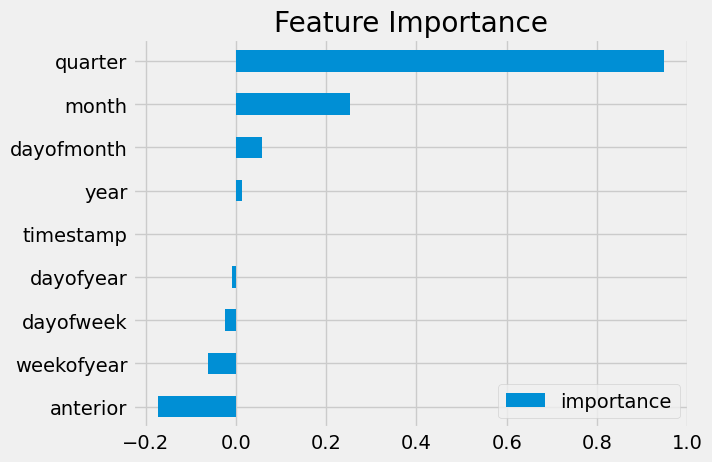

In [101]:
fi = pd.DataFrame(data=reg1.feature_importances_,
             index=reg1.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

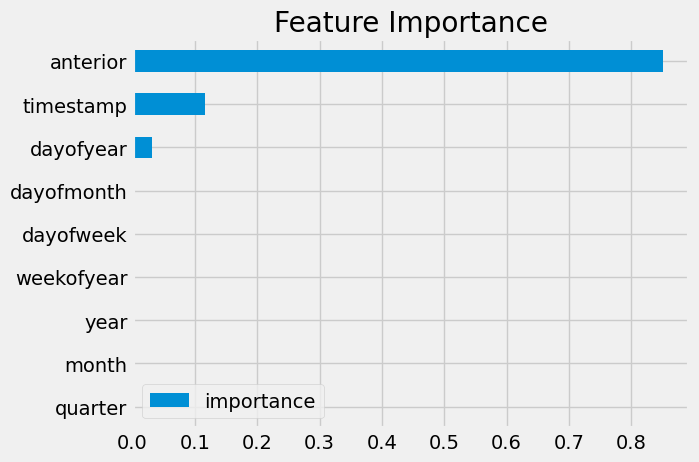

In [102]:
fi = pd.DataFrame(data=reg2.feature_importances_,
             index=reg2.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Predicciones

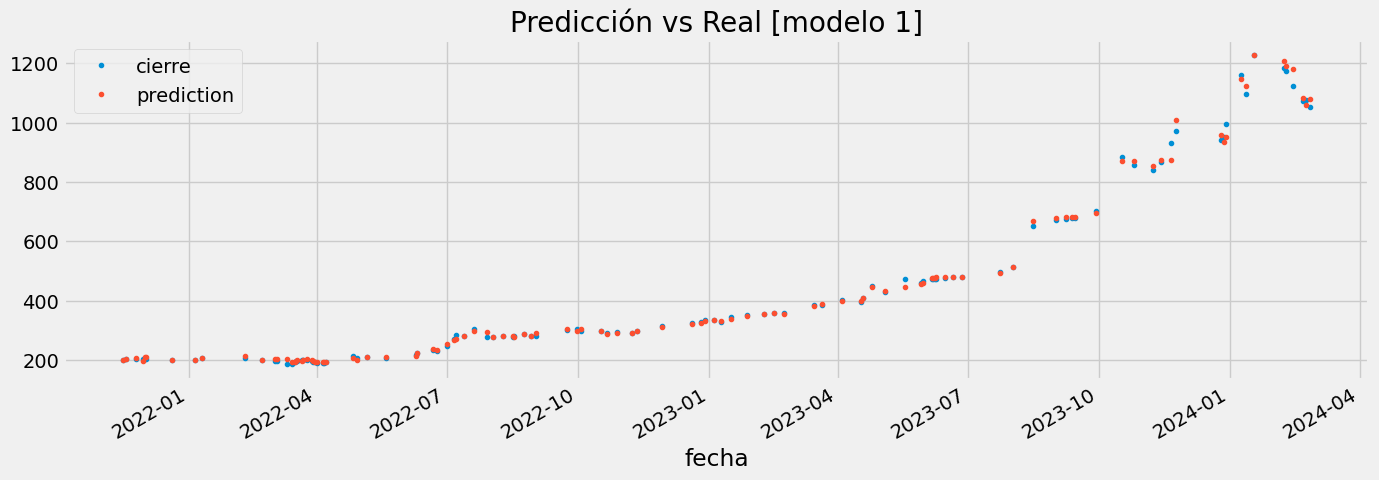

In [103]:
y = y_test.to_frame()
y['prediction'] = reg1.predict(X_test)

y.plot(figsize=(15, 5),
       title='Predicción vs Real [modelo 1]',
       style='.',
       color=[color_pal[0], color_pal[1]])

plt.show()

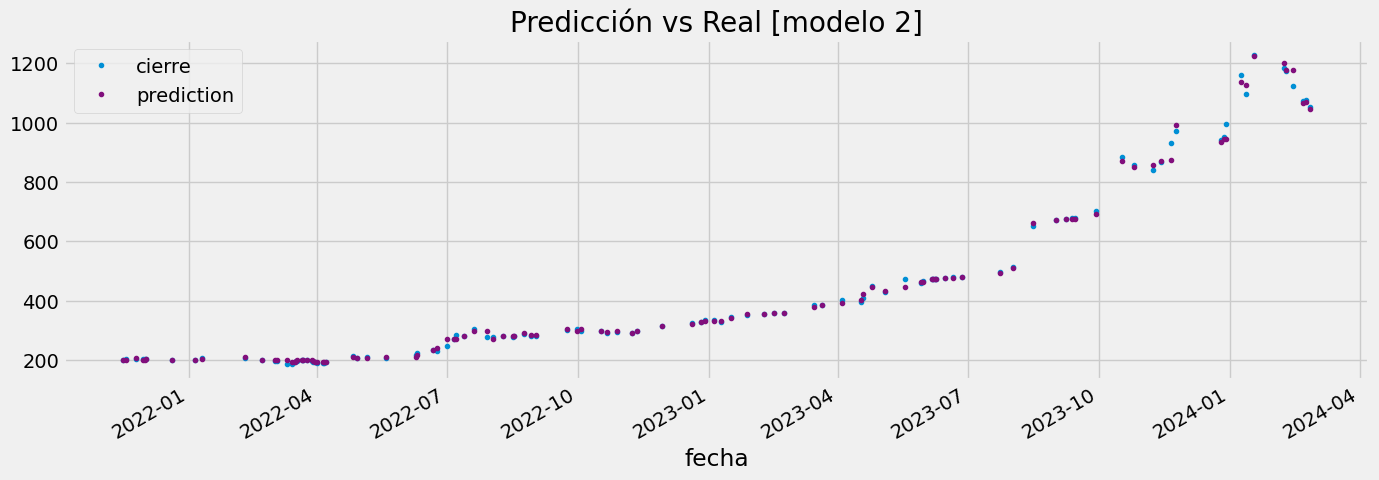

In [104]:
y2 = y_test.to_frame()
y2['prediction'] = reg2.predict(X_test)

y2.plot(figsize=(15, 5),
       title='Predicción vs Real [modelo 2]',
       style='.',
       color=[color_pal[0], color_pal[5]])

plt.show()

## Error cuadratico medio

In [105]:
mse1 = mean_squared_error(y['cierre'], y['prediction'])
mse2 = mean_squared_error(y2['cierre'], y2['prediction'])
print(f"Mean Squared Error [modelo 1]: {mse1}")
print(f"Mean Squared Error [modelo 2]: {mse2}")

Mean Squared Error [modelo 1]: 150.87536586433006
Mean Squared Error [modelo 2]: 132.37921076946142


## Extendiendo las predicciones

In [106]:
def simulateDays(df, reg, days=1):
    """
    Agrega al df la cantidad de dias que se le pase por parametro
    a partir del ultimo dia del df.
   
    """
    d = 0
    
    last_day_input = df.tail(1).iloc[0]
    last_value = last_day_input['cierre']
    last_date = dt.datetime.fromtimestamp(last_day_input['timestamp'])
    next_date = last_date + dt.timedelta(days=1)
    
    mdf = df.tail(1).copy()

    while d < days:
        curr_day_features = {
            "anterior": last_value,
            "timestamp": last_day_input['timestamp'] + 86400,
            "dayofweek": next_date.weekday(),
            "quarter": pd.Timestamp(next_date).quarter,
            "month": next_date.month,
            "year": next_date.year,
            "dayofyear": next_date.timetuple().tm_yday,
            "dayofmonth": next_date.day,
            "weekofyear": next_date.isocalendar().week,
        }

        curr_day_target = reg.predict(pd.DataFrame(curr_day_features, index=[0]))[0]
        curr_day_features['prediction'] = curr_day_target 
        last_value = curr_day_target

        mdf.loc[next_date] = curr_day_features
        
        next_date = next_date + dt.timedelta(days=1)
        last_day_input = curr_day_features
        d+=1

    return mdf

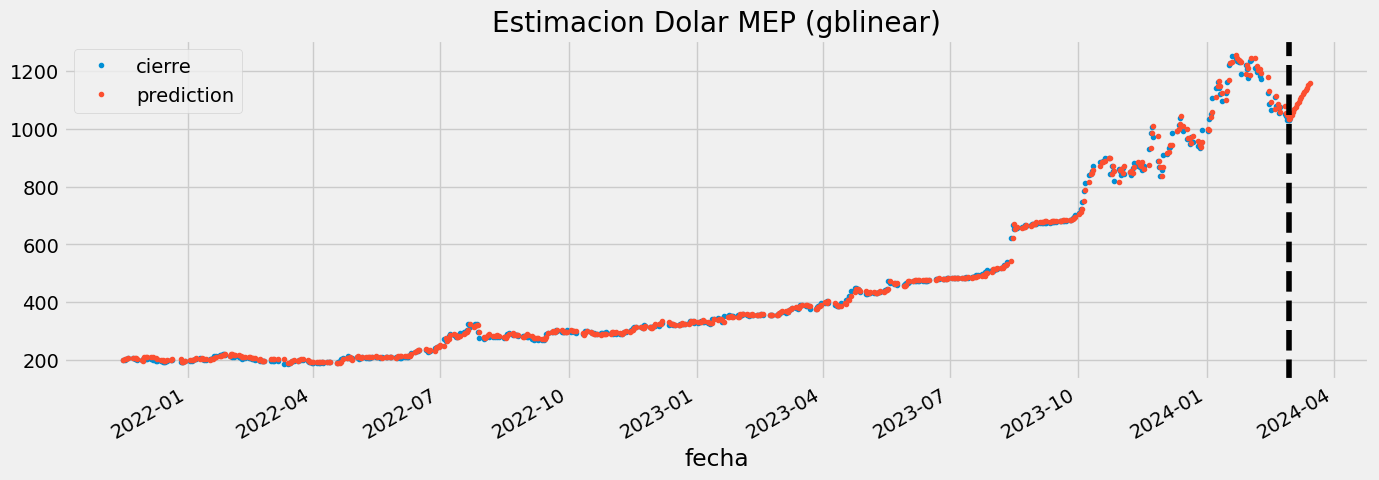

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))

df['prediction'] = reg1.predict(df[features])
preds = simulateDays(df, reg1, 15)

df_concat = pd.concat([df, preds])

df_concat.loc[df_concat.index > '05-01-2020', ['cierre', 'prediction']] \
         .plot(ax=ax, title='Estimacion Dolar MEP (gblinear)', color=color_pal, style='.')


last_day_input = df.tail(1).iloc[0]
last_date = dt.datetime.fromtimestamp(last_day_input['timestamp'])
next_date = last_date + dt.timedelta(days=1)
ax.axvline(last_date, color='black', ls='--') 

plt.show()

In [111]:
preds.head(2)

,anterior,minimo,maximo,cierre,timestamp,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
fecha,,,,,,,,,,,,,
2024-02-29,1031.25,1026.16,1046.08,1028.94,1.709176e+09,3,1,2,2024,60,29,9,1032.967041
2024-03-01,1028.94,NaN,NaN,NaN,1.709262e+09,4,1,3,2024,61,1,9,1038.647095
